In [1]:
# Importing libraries
import time
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.datasets as dsets
import argparse
import json
import math
import os

In [2]:
class DataLoader:

    def __init__(self,X,y,batch_size):
        self.X, self.y = X, y 
        self.batch_size = batch_size
        self.n_samples = len(y)
        self.idx = 0

    def __len__(self):
        length = self.n_samples // self.batch_size
        if self.n_samples > length * self.batch_size:
            length += 1
        return length

    def __iter__(self):
        return self    

    def __next__(self):
        if self.idx >= self.n_samples:
            self.idx = 0
            rnd_idx = torch.randperm(self.n_samples)
            self.X = self.X[rnd_idx]
            self.y = self.y[rnd_idx]

        idx_end = min(self.idx+self.batch_size, self.n_samples)
        batch_X = self.X[self.idx:idx_end]
        batch_y = self.y[self.idx:idx_end]
        self.idx = idx_end

        return batch_X,batch_y


def load_fmnist(training_size, batch_size=100):
    train_set = dsets.FashionMNIST('data/fashionmnist', train=True, download=True)
    train_X, train_y = train_set.data[0:training_size].float()/255, \
                       to_one_hot(train_set.targets[0:training_size])
    train_loader = DataLoader(train_X, train_y, batch_size)

    test_set = dsets.FashionMNIST('data/fashionmnist', train=False,download=True)
    test_X, test_y = test_set.data.float()/255, \
                     to_one_hot(test_set.targets)
    test_loader = DataLoader(test_X, test_y, batch_size)

    return train_loader, test_loader


def load_cifar10(training_size, batch_size=100):
    """
    load cifar10 dataset. Notice that here we only use examples
    corresponding to label 0 and 1. Thus the training_size is at 
    most 10000.
    """
    train_set = dsets.CIFAR10('data/cifar10', train=True, download=True)
    train_X,train_y = modify_cifar_data(train_set.data, train_set.targets, training_size)
    train_loader = DataLoader(train_X, train_y, batch_size)

    test_set = dsets.CIFAR10('data/cifar10', train=False, download=True)
    test_X,test_y = modify_cifar_data(test_set.data, test_set.targets)
    test_loader = DataLoader(test_X, test_y, batch_size)

    return train_loader, test_loader


def modify_cifar_data(X, y, n_samples=-1):
    X = torch.from_numpy(X.transpose([0,3,1,2]))
    y = torch.LongTensor(y)

    X_t = torch.Tensor(50000,3,32,32)
    y_t = torch.LongTensor(50000)
    idx = 0
    for i in range(len(y)):
        if y[i] == 0 or y[i] == 1:
            y_t[idx] = y[i]
            X_t[idx,:,:,:] = X[i,:,:,:]
            idx += 1
    X = X_t[0:idx]
    y = y_t[0:idx] 

    if n_samples > 1:
        X = X[0:n_samples]
        y = y[0:n_samples]

    # preprocess the data
    X = X.float()/255.0
    y = to_one_hot(y) 

    return X, y


def to_one_hot(labels):
    if labels.ndimension()==1:
        labels.unsqueeze_(1)
    n_samples = labels.shape[0]
    n_classes = labels.max()+1

    one_hot_labels = torch.FloatTensor(n_samples,n_classes)
    one_hot_labels.zero_()
    one_hot_labels.scatter_(1, labels, 1)

    return one_hot_labels

train_loader, test_loader = load_cifar10(training_size=10000,batch_size=500)
for i in range(30):
    batch_x, batch_y = next(train_loader)
    print(i, batch_x.shape, batch_y.shape)

for i in range(4):
    batch_x, batch_y = next(test_loader)
    print(i, batch_x.shape, batch_y.shape)

Files already downloaded and verified
Files already downloaded and verified
0 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
1 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
2 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
3 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
4 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
5 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
6 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
7 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
8 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
9 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
10 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
11 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
12 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
13 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
14 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
15 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
16 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
17 torch.Size([500, 3, 32, 32]) t

Training models using pytorch. Serveral parameters are passed into the function: model (sgd), criterion (MSE Loss), dataloader (loading the training data), batch size of 1000 and 50000 iterations. We set all gradients of the model to zero, go through the batch gradient descent once with the given batch size. The avg_accuracy is changed by 10% of the minibatch each iteraiton. Every 200 iterations, we print iterations, loss, and accuracy.

In [3]:
def train(model, criterion, optimizer, dataloader, batch_size, n_iters=50000, verbose=True):
    model.train()
    acc_avg = 0  
    loss_avg = 0 
    since = time.time()
    for current_iter in range(n_iters):
        optimizer.zero_grad()
        loss,acc = compute_minibatch_GD(model, criterion, dataloader, batch_size)
        optimizer.step()
        if acc_avg > 0:
            acc_avg = 0.9 * acc_avg + 0.1 * acc
        else:
            acc_avg = acc
        if loss_avg > 0:
            loss_avg = 0.9 * loss_avg + 0.1 * loss
        else: 
            loss_avg = loss
        if current_iter%200 == 0:
            now = time.time()
            print('%d/%d, took %.0f seconds, train_loss: %.1e, train_acc: %.2f'%(
                    current_iter+1, n_iters, now-since, loss_avg, acc_avg))
            since = time.time() 

Computing the minibatch gradient while iterating through the data from the data loader in increments of the batch size. Targets are the deisired outputs and logits are the predictions. Accuracy and lass are averaged across the batches.

In [4]:
def compute_minibatch_GD(model, criterion, dataloader, batch_size):
    loss = 0
    acc = 0
    n_loads = batch_size // dataloader.batch_size

    for i in range(n_loads):
        inputs, targets = next(dataloader)
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = model(inputs)
        E = criterion(logits,targets)
        E.backward()
        acc += accuracy(logits.data,targets)
        loss += E.item()
        
    for p in model.parameters():
        p.grad.data /= n_loads
    loss=loss/n_loads
    acc=acc/n_loads
    return loss, acc

We set the number of rows to n, which is the total number of targets/predictions. We compare the targets to the predictions and get the accuracy from the matches. 

In [5]:
def accuracy(logits, targets):
    n = logits.shape[0]
    if targets.ndimension() == 2:
        _, y_trues = torch.max(targets,1)
    else:
        y_trues = targets 
    _, y_preds = torch.max(logits,1)

    acc = (y_trues==y_preds).float().sum()
    acc=acc*100.0/n 
    return acc

In [6]:
def eval_accuracy(model, criterion, dataloader):
    model.eval()
    n_batchs = len(dataloader)
    dataloader.idx = 0

    loss_t, acc_t = 0.0, 0.0
    for i in range(n_batchs):
        inputs,targets = next(dataloader)
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = model(inputs)
        loss_t += criterion(logits,targets).item()
        acc_t += accuracy(logits.data,targets)

    return loss_t/n_batchs, acc_t/n_batchs

In [7]:
'''
Modified from https://github.com/pytorch/vision.git
'''


__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features,feature_size=512,num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(feature_size, 128),
            nn.ReLU(True),
            nn.Linear(128,num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [16, 'M', 16, 'M', 32, 'M',  64, 'M', 64, 'M'],
    'A1': [16, 'M', 32, 'M', 32, 32, 'M', 64, 64, 'M', 128, 128, 'M'],
    'A2': [32, 'M', 64, 'M', 64, 64, 'M', 128, 128, 'M', 256, 256, 'M'],
    'A3': [64, 'M', 128, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'A4': [128, 'M', 256, 'M', 256, 256, 'M', 512, 512, 'M', 1024, 1024, 'M'],
    'B': [16, 16, 'M', 32, 32, 'M', 64, 64, 'M', 128, 128, 'M', 128, 128, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
          512, 512, 512, 512, 'M'],
}


def vgg11(num_classes=10):
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']),feature_size=64,num_classes=num_classes)


def vgg11_big(num_classes=10):
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A3']),cfg['A3'][-2],num_classes)

def vgg11_bn(num_classes):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13(num_classes=10):
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']),num_classes)


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))


In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(1,6,5,stride=1) # 28-5+1=24
        self.conv2 = nn.Conv2d(6,16,5,stride=1) # 12-5+1=8
        self.fc1 = nn.Linear(4*4*16,200)
        self.fc2 = nn.Linear(200,10)

    def forward(self,x):
        if x.ndimension()==3:
            x = x.unsqueeze(0)
        o = F.relu(self.conv1(x))
        o = F.avg_pool2d(o,2,2)

        o = F.relu(self.conv2(o))
        o = F.avg_pool2d(o,2,2)

        o = o.view(o.shape[0],-1)
        o = self.fc1(o)
        o = F.relu(o)
        o = self.fc2(o)
        return o

class FNN(nn.Module):
    def __init__(self):
        super(FNN,self).__init__()
        self.net = nn.Sequential(nn.Linear(784,500),
                            nn.ReLU(),
                            nn.Linear(500,500),
                            nn.ReLU(),
                            nn.Linear(500,500),
                            nn.ReLU(),
                            nn.Linear(500,10))

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        o = self.net(x)
        return o

def lenet():
    return LeNet()

def fnn():
    return FNN()

In [9]:
def eigen_variance(net, criterion, dataloader, n_iters=10, tol=1e-2, verbose=False):
    n_parameters = num_parameters(net)
    v0 = torch.randn(n_parameters)

    Av_func = lambda v: variance_vec_prod(net, criterion, dataloader, v)
    mu = power_method(v0, Av_func, n_iters, tol, verbose)
    return mu


def eigen_hessian(net, criterion, dataloader, n_iters=10, tol=1e-2, verbose=False):
    n_parameters = num_parameters(net)
    v0 = torch.randn(n_parameters)

    Av_func = lambda v: hessian_vec_prod(net, criterion, dataloader, v)
    mu = power_method(v0, Av_func, n_iters, tol, verbose)
    return mu


def variance_vec_prod(net, criterion, dataloader, v):
    X, y = dataloader.X, dataloader.y
    Av, Hv, n_samples = 0, 0, len(y)

    for i in range(n_samples):
        bx, by = X[i:i+1].cuda(), y[i:i+1].cuda()
        Hv_i = Hv_batch(net, criterion, bx, by, v)
        Av_i = Hv_batch(net, criterion, bx, by, Hv_i)
        Av += Av_i
        Hv += Hv_i
    Av /= n_samples
    Hv /= n_samples
    H2v = hessian_vec_prod(net, criterion, dataloader, Hv)
    return Av - H2v


def hessian_vec_prod(net, criterion, dataloader, v):
    Hv_t = 0
    n_batchs = len(dataloader)
    dataloader.idx = 0
    for _ in range(n_batchs):
        bx, by = next(dataloader)
        Hv_t += Hv_batch(net, criterion, bx.cuda(), by.cuda(), v)

    return Hv_t/n_batchs


def Hv_batch(net, criterion, batch_x, batch_y, v):
    """
    Hessian vector multiplication
    """
    net.eval()
    logits = net(batch_x)
    loss = criterion(logits, batch_y)

    grads = autograd.grad(loss, net.parameters(), create_graph=True, retain_graph=True)
    idx, res = 0, 0
    for grad_i in grads:
        ng = torch.numel(grad_i)
        v_i = v[idx:idx+ng].cuda()
        res += torch.dot(v_i, grad_i.view(-1))
        idx += ng

    Hv = autograd.grad(res, net.parameters())
    Hv = [t.data.cpu().view(-1) for t in Hv]
    Hv = torch.cat(Hv)
    return Hv


def power_method(v0, Av_func, n_iters=10, tol=1e-3, verbose=False):
    mu = 0
    v = v0/v0.norm()
    for i in range(n_iters):
        time_start = time.time()

        Av = Av_func(v)
        mu_pre = mu
        mu = torch.dot(Av,v).item()
        v = Av/Av.norm()

        if abs(mu-mu_pre)/abs(mu) < tol:
            break
        if verbose:
            print('%d-th step takes %.0f seconds, \t %.2e'%(i+1,time.time()-time_start,mu))
    return mu


def num_parameters(net):
    """
    return the number of parameters for given model
    """
    n_parameters = 0
    for para in net.parameters():
        n_parameters += para.data.numel()

    return n_parameters


In [10]:
# Setting Hyperparameters
gpuid = '0,'
dataset= 'cifar10'
n_samples = 1000
load_size = 1000
optimizer = 'sgd'
n_iters = 1000
batch_size = 1000
learning_rate = 1e-1
momentum = 0.0
os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

In [11]:
criterion = torch.nn.MSELoss().cuda()

if dataset == 'fashionmnist':
        train_loader, test_loader = load_fmnist(training_size=n_samples, batch_size=load_size)
        net = fnn().cuda()
        
elif dataset == 'cifar10':
        train_loader, test_loader = load_cifar10(training_size=n_samples, batch_size=load_size)
        net = vgg11(num_classes=2).cuda()

if optimizer == 'sgd':
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
elif optimizer == 'adam':
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

print(optimizer)

print('===> Architecture:')
print(net)

print('===> Start training')
train(net, criterion, optimizer, train_loader, batch_size, n_iters, verbose=True)

train_loss, train_accuracy = eval_accuracy(net, criterion, train_loader)
test_loss, test_accuracy = eval_accuracy(net, criterion, test_loader)
print('===> Solution: ')
print('\t train loss: %.2e, acc: %.2f' % (train_loss, train_accuracy))
print('\t test loss: %.2e, acc: %.2f' % (test_loss, test_accuracy))

Files already downloaded and verified
Files already downloaded and verified
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.0
    nesterov: False
    weight_decay: 0
)
===> Architecture:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Co

In [12]:
print('===> Compute sharpness:')
sharpness = eigen_hessian(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=False)
print('Sharpness is %.2e\n'%(sharpness))

print('===> Compute non-uniformity:')
non_uniformity = math.sqrt(eigen_variance(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=True))
print('Non-uniformity is %.2e\n'%(non_uniformity))

===> Compute sharpness:
Sharpness is 1.77e+01

===> Compute non-uniformity:


KeyboardInterrupt: 

In [14]:
# Setting Hyperparameters
gpuid = '0,'
dataset= 'fashionmnist'
n_samples = 1000
optimizer = 'sgd'
momentum = 0.0
os.environ["CUDA_VISIBLE_DEVICES"] = gpuid


train_accuracies_list = []
test_accuracies_list = []
sharpnesses_list = []

# [lr, batch_size]
configs = [
    [0.1, 10],
    [0.1, 400],
    [0.3, 1000],
    [0.5, 1000],
]

n_iters=50
total_iters=3000

for config in configs:
    learning_rate = config[0]
    batch_size = config[1]
    
    criterion = torch.nn.MSELoss().cuda()
    
    train_loader, test_loader = load_fmnist(training_size=n_samples, batch_size=batch_size)
    net = fnn().cuda()   
    
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    
    train_accuracies = []
    test_accuracies = []
    sharpnesses = []
    
    for i in range(total_iters//n_iters):
        
        print(i*n_iters)
        train(net, criterion, optimizer, train_loader, batch_size, n_iters, verbose=False)

        train_loss, train_accuracy = eval_accuracy(net, criterion, train_loader)
        test_loss, test_accuracy = eval_accuracy(net, criterion, test_loader)
        sharpness = eigen_hessian(net, criterion, train_loader, n_iters=n_iters, tol=learning_rate, verbose=False)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        sharpnesses.append(sharpness)


        print("trn", train_loss, train_accuracy)
        print("tst", test_loss, test_accuracy)
        print("sharpness", sharpness)

        
    train_accuracies_list.append(train_accuracies)
    test_accuracies_list.append(test_accuracies)
    sharpnesses_list.append(sharpnesses)

0
1/50, took 0 seconds, train_loss: 1.0e-01, train_acc: 10.00
trn 0.08418802596628666 tensor(44.1000, device='cuda:0')
tst 0.08444287563860417 tensor(41.4400, device='cuda:0')
sharpness 0.7125553488731384
50
1/50, took 0 seconds, train_loss: 8.2e-02, train_acc: 40.00
trn 0.07859047658741475 tensor(58.2000, device='cuda:0')
tst 0.07925684345513583 tensor(53.2400, device='cuda:0')
sharpness 0.9419432878494263
100
1/50, took 0 seconds, train_loss: 8.0e-02, train_acc: 50.00
trn 0.07315150000154973 tensor(57.4000, device='cuda:0')
tst 0.0740744197666645 tensor(54.9700, device='cuda:0')
sharpness 1.1995176076889038
150
1/50, took 0 seconds, train_loss: 7.8e-02, train_acc: 30.00
trn 0.06835601091384888 tensor(63.1000, device='cuda:0')
tst 0.06955875424295664 tensor(58.3900, device='cuda:0')
sharpness 1.5841617584228516
200
1/50, took 0 seconds, train_loss: 6.2e-02, train_acc: 60.00
trn 0.06417632073163987 tensor(67.1000, device='cuda:0')
tst 0.06558421260863542 tensor(63.6200, device='cuda:0'

tst 0.03579165112879127 tensor(78.2300, device='cuda:0')
sharpness 4.8714599609375
2000
1/50, took 0 seconds, train_loss: 1.2e-02, train_acc: 100.00
trn 0.027296833386644723 tensor(87.2000, device='cuda:0')
tst 0.03686218111403287 tensor(77.8000, device='cuda:0')
sharpness 5.027917385101318
2050
1/50, took 0 seconds, train_loss: 3.2e-02, train_acc: 100.00
trn 0.026135817235335708 tensor(87.4000, device='cuda:0')
tst 0.03577764749713242 tensor(78.4000, device='cuda:0')
sharpness 4.539773464202881
2100
1/50, took 0 seconds, train_loss: 4.4e-02, train_acc: 50.00
trn 0.02541937041096389 tensor(88.8000, device='cuda:0')
tst 0.03507711437903344 tensor(78.6100, device='cuda:0')
sharpness 4.526273727416992
2150
1/50, took 0 seconds, train_loss: 1.8e-02, train_acc: 100.00
trn 0.02489338747691363 tensor(88.7000, device='cuda:0')
tst 0.034613395838532596 tensor(79.0500, device='cuda:0')
sharpness 3.6728663444519043
2200
1/50, took 0 seconds, train_loss: 3.5e-02, train_acc: 80.00
trn 0.02481867606

1/50, took 0 seconds, train_loss: 3.6e-02, train_acc: 79.75
trn 0.035088274627923965 tensor(79.5000, device='cuda:0')
tst 0.04078841164708138 tensor(73.8600, device='cuda:0')
sharpness 6.987311840057373
1000
1/50, took 0 seconds, train_loss: 3.5e-02, train_acc: 80.00
trn 0.03436583901445071 tensor(80.7500, device='cuda:0')
tst 0.040353511422872544 tensor(74.4800, device='cuda:0')
sharpness 7.209164619445801
1050
1/50, took 0 seconds, train_loss: 3.4e-02, train_acc: 82.25
trn 0.034065806617339454 tensor(81.0833, device='cuda:0')
tst 0.03984121695160866 tensor(74.9300, device='cuda:0')
sharpness 6.557136535644531
1100
1/50, took 0 seconds, train_loss: 3.2e-02, train_acc: 84.75
trn 0.03312228247523308 tensor(81.6667, device='cuda:0')
tst 0.03941051214933396 tensor(75.2700, device='cuda:0')
sharpness 7.2286248207092285
1150
1/50, took 0 seconds, train_loss: 3.3e-02, train_acc: 82.25
trn 0.03202220362921556 tensor(83.8333, device='cuda:0')
tst 0.03902587041258812 tensor(75.7500, device='cud

trn 0.018115971858302753 tensor(92.8333, device='cuda:0')
tst 0.03329105123877525 tensor(80.1300, device='cuda:0')
sharpness 11.176900863647461
2950
1/50, took 0 seconds, train_loss: 1.7e-02, train_acc: 94.00
trn 0.017494533210992813 tensor(93.5000, device='cuda:0')
tst 0.0331478363275528 tensor(80.1500, device='cuda:0')
sharpness 13.10273551940918
0
1/50, took 0 seconds, train_loss: 1.0e-01, train_acc: 8.50
trn 0.07319681346416473 tensor(62.6000, device='cuda:0')
tst 0.07389944940805435 tensor(58.3400, device='cuda:0')
sharpness 0.8925225734710693
50
1/50, took 0 seconds, train_loss: 7.3e-02, train_acc: 62.60
trn 0.059336107224226 tensor(62.1000, device='cuda:0')
tst 0.0609502524137497 tensor(59.7900, device='cuda:0')
sharpness 2.1394996643066406
100
1/50, took 0 seconds, train_loss: 5.9e-02, train_acc: 62.10
trn 0.05009781941771507 tensor(67.2000, device='cuda:0')
tst 0.05268188938498497 tensor(64.3700, device='cuda:0')
sharpness 3.9669742584228516
150
1/50, took 0 seconds, train_los

sharpness 6.2516984939575195
1900
1/50, took 0 seconds, train_loss: 1.0e-02, train_acc: 97.30
trn 0.009221834130585194 tensor(98.1000, device='cuda:0')
tst 0.03178605679422617 tensor(80.4000, device='cuda:0')
sharpness 5.480527877807617
1950
1/50, took 0 seconds, train_loss: 9.2e-03, train_acc: 98.10
trn 0.009706133976578712 tensor(97.8000, device='cuda:0')
tst 0.03224503304809332 tensor(80.6600, device='cuda:0')
sharpness 5.896471977233887
2000
1/50, took 0 seconds, train_loss: 9.7e-03, train_acc: 97.80
trn 0.009343765676021576 tensor(97.4000, device='cuda:0')
tst 0.031641412526369095 tensor(80.5100, device='cuda:0')
sharpness 5.989984035491943
2050
1/50, took 0 seconds, train_loss: 9.3e-03, train_acc: 97.40
trn 0.008863500319421291 tensor(98.1000, device='cuda:0')
tst 0.03249707613140344 tensor(80.7400, device='cuda:0')
sharpness 6.032805919647217
2100
1/50, took 0 seconds, train_loss: 8.9e-03, train_acc: 98.10
trn 0.008543254807591438 tensor(98.2000, device='cuda:0')
tst 0.032436592

trn 0.013793555088341236 tensor(94.9000, device='cuda:0')
tst 0.03229718189686537 tensor(80.3400, device='cuda:0')
sharpness 3.7465453147888184
900
1/50, took 0 seconds, train_loss: 1.4e-02, train_acc: 94.90
trn 0.015494327060878277 tensor(93.5000, device='cuda:0')
tst 0.03319800160825252 tensor(79.7000, device='cuda:0')
sharpness 3.2338051795959473
950
1/50, took 0 seconds, train_loss: 1.5e-02, train_acc: 93.50
trn 0.013371606357395649 tensor(95.4000, device='cuda:0')
tst 0.032460782863199714 tensor(80.0100, device='cuda:0')
sharpness 3.6717207431793213
1000
1/50, took 0 seconds, train_loss: 1.3e-02, train_acc: 95.40
trn 0.011535578407347202 tensor(96.8000, device='cuda:0')
tst 0.03217224013060331 tensor(79.9700, device='cuda:0')
sharpness 3.39262056350708
1050
1/50, took 0 seconds, train_loss: 1.2e-02, train_acc: 96.80
trn 0.010874674655497074 tensor(96.8000, device='cuda:0')
tst 0.0318758113309741 tensor(80.0200, device='cuda:0')
sharpness 3.937758207321167
1100
1/50, took 0 seconds

trn 0.001027195481583476 tensor(100.0000, device='cuda:0')
tst 0.031016301736235617 tensor(80.8000, device='cuda:0')
sharpness 3.2483558654785156
2850
1/50, took 0 seconds, train_loss: 1.0e-03, train_acc: 100.00
trn 0.0010544053511694074 tensor(100.0000, device='cuda:0')
tst 0.03090326562523842 tensor(80.8800, device='cuda:0')
sharpness 3.3265233039855957
2900
1/50, took 0 seconds, train_loss: 1.1e-03, train_acc: 100.00
trn 0.0024054974783211946 tensor(99.9000, device='cuda:0')
tst 0.0316835941746831 tensor(80.0300, device='cuda:0')
sharpness 3.6461355686187744
2950
1/50, took 0 seconds, train_loss: 2.4e-03, train_acc: 99.90
trn 0.0009092063992284238 tensor(100.0000, device='cuda:0')
tst 0.030862024612724782 tensor(80.7900, device='cuda:0')
sharpness 3.5947961807250977


[tensor(44.1000, device='cuda:0'), tensor(58.2000, device='cuda:0'), tensor(57.4000, device='cuda:0'), tensor(63.1000, device='cuda:0'), tensor(67.1000, device='cuda:0'), tensor(58.4000, device='cuda:0'), tensor(68.3000, device='cuda:0'), tensor(67.2000, device='cuda:0'), tensor(69.4000, device='cuda:0'), tensor(71.1000, device='cuda:0'), tensor(70.1000, device='cuda:0'), tensor(73.1000, device='cuda:0'), tensor(73.4000, device='cuda:0'), tensor(73.3000, device='cuda:0'), tensor(74.4000, device='cuda:0'), tensor(76.8000, device='cuda:0'), tensor(74.7000, device='cuda:0'), tensor(73.6000, device='cuda:0'), tensor(77.8000, device='cuda:0'), tensor(79.7000, device='cuda:0'), tensor(79.3000, device='cuda:0'), tensor(78., device='cuda:0'), tensor(80.8000, device='cuda:0'), tensor(80.1000, device='cuda:0'), tensor(80.8000, device='cuda:0'), tensor(82.1000, device='cuda:0'), tensor(82., device='cuda:0'), tensor(82., device='cuda:0'), tensor(82.1000, device='cuda:0'), tensor(83.7000, device='c

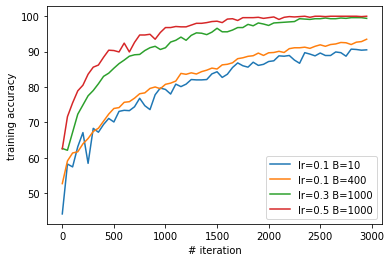

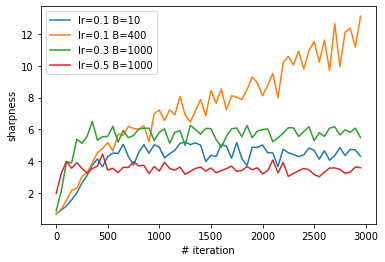

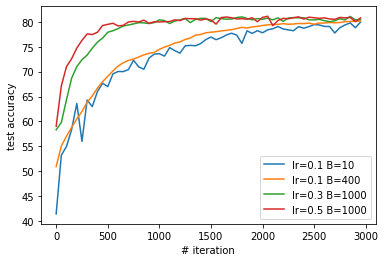

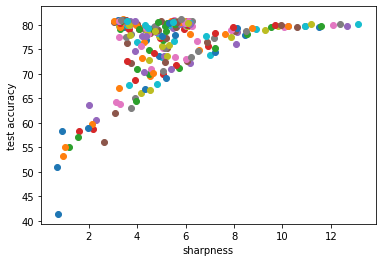

In [16]:
import matplotlib.pyplot as plt

iterations = [i for i in range(0, total_iters, n_iters)]

print(train_accuracies_list[0])

# training
for i in range(len(train_accuracies_list)):
    plt.plot(iterations, train_accuracies_list[i], label="lr=" + str(configs[i][0]) + " B=" + str(configs[i][1]))
plt.legend()
plt.xlabel("# iteration")
plt.ylabel("training accuracy")
plt.show()

# sharpness
for i in range(len(sharpnesses_list)):
    plt.plot(iterations, sharpnesses_list[i], label="lr=" + str(configs[i][0]) + " B=" + str(configs[i][1]))
plt.legend()
plt.xlabel("# iteration")
plt.ylabel("sharpness")
plt.show()

# testing
for i in range(len(test_accuracies_list)):
    plt.plot(iterations, test_accuracies_list[i], label="lr=" + str(configs[i][0]) + " B=" + str(configs[i][1]))
plt.legend()
plt.xlabel("# iteration")
plt.ylabel("test accuracy")
plt.show()

# sharpness vs testing
for i in range(len(sharpnesses_list)):
    for j in range(len(sharpnesses_list[i])):
        plt.scatter(sharpnesses_list[i][j], test_accuracies_list[i][j].cpu())
plt.xlabel("sharpness")
plt.ylabel("test accuracy")
plt.show()